<a href="https://colab.research.google.com/github/jay900411/DataAnalysis/blob/main/%E5%8C%96%E5%B7%A5%E5%BB%A0%E5%8F%8D%E6%87%89%E5%99%A8%E6%BA%AB%E5%BA%A6%E7%9C%9F%E5%AF%A6%E5%95%8F%E9%A1%8C%E5%AF%A6%E4%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.疫情嚴重時,該化工廠產量增加,化學反應爐的生產運
作時間為 18 個小時;經理為了產線的生產效益提高,告
訴資料科學家,反應器溫度是很重要的關鍵,因此經理
希望你能跟公司的資訊管理人員合作,看看能不能從中
央的控制軟體的紀錄檔,找出影響溫度的關鍵因子。
2.找出關鍵因子後,經理希望該名資料科學家可不可以再
幫忙利用人工智慧的技術幫忙提高產量?

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
# 用 RandomForest 替代了 XGBoost，因為它在標準環境中更常見
# 功能相同：建立高準確度的模擬機並提供特徵重要性
from sklearn.ensemble import RandomForestRegressor
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['DejaVu Sans'] # Colab 預設字體
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題

In [30]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
data = pd.read_csv("/content/gdrive/My Drive/20211006.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
data.head()

,0,Time,MFG,RB.01.Reactor_Temperature.PV,RB.01a.Reactor_Temperature.PV.HH,RB.01b.Reactor_Temperature.PV.PH,RB.01c.Reactor_Temperature.PV.PL,RB.01d.Reactor_Temperature.PV.LL,RB.02.Reactor_Temperature.SV,RB.03.Reactor_Pressure.PV,...,RB.13.Rareactor_Jacket_Flow_Rate.PV,RB.14.Jacket_Outlet_Temperature.PV,RB.15.Tank_Level.PV,RB.16.Rareactor_Jacket_Steam_Flow_Rate.PV,RB.17.Reactor_Process_start_flag.PV,RB.18.Reaction_Process_Pure_Water_Pour_Down_flag.PV,RB.19.Reaction_Process_Pure_Water_Pour_Down_Set_Value.BSET,RB.20.Reaction_Process_Pure_Water_Pour_Down_Measured_Value.SUM,RB.21.Reaction_Process_Pure_Water_Pour_Down_Operator_Numbering.DT,RB.22.Reaction_Process_Conversion_Rate.PV
0,1,2.021100e+13,SM,31.36,40,38,20,18,32.5,2.66,...,54.93,10.90,243.81,748.32,2,NaN,200,220.61,202101264,31.09
1,2,2.021100e+13,SM,31.36,40,38,20,18,32.5,2.66,...,54.89,11.00,243.82,741.71,2,NaN,200,220.61,202101264,31.09
2,3,2.021100e+13,SM,31.36,40,38,20,18,32.5,2.66,...,54.84,11.06,243.80,766.37,2,NaN,200,220.61,202101264,31.09
3,4,2.021100e+13,SM,31.36,40,38,20,18,32.5,2.66,...,54.85,11.16,243.81,820.76,2,NaN,200,220.61,202101264,31.09
4,5,2.021100e+13,SM,31.36,40,38,20,18,32.5,2.66,...,54.67,11.21,243.81,836.21,2,NaN,200,220.61,202101264,31.09


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10596 entries, 0 to 10595
Data columns (total 33 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   0                                                                  10596 non-null  int64  
 1   Time                                                               10596 non-null  float64
 2   MFG                                                                10596 non-null  object 
 3   RB.01.Reactor_Temperature.PV                                       10596 non-null  float64
 4   RB.01a.Reactor_Temperature.PV.HH                                   10596 non-null  int64  
 5   RB.01b.Reactor_Temperature.PV.PH                                   10596 non-null  int64  
 6   RB.01c.Reactor_Temperature.PV.PL                                   10596 non-null  int64  
 7   RB.01d.Reactor_Tempera

In [35]:
df = data.drop(['0', 'MFG'], axis = 1)
df['Elapsed_Seconds'] = df['Time'] - df['Time'].min()
df = df.drop('Time', axis=1)

df = df.drop('RB.18.Reaction_Process_Pure_Water_Pour_Down_flag.PV', axis=1)
# 將 RB.10 和 RB.20 的 NaN 填補為 0 (假設 NaN = 0 流率/測量值)
df['RB.10.AN_Flow_Rate.PV'] = df['RB.10.AN_Flow_Rate.PV'].fillna(0)
df['RB.20.Reaction_Process_Pure_Water_Pour_Down_Measured_Value.SUM'] = df['RB.20.Reaction_Process_Pure_Water_Pour_Down_Measured_Value.SUM'].fillna(0)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10596 entries, 0 to 10595
Data columns (total 30 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   RB.01.Reactor_Temperature.PV                                       10596 non-null  float64
 1   RB.01a.Reactor_Temperature.PV.HH                                   10596 non-null  int64  
 2   RB.01b.Reactor_Temperature.PV.PH                                   10596 non-null  int64  
 3   RB.01c.Reactor_Temperature.PV.PL                                   10596 non-null  int64  
 4   RB.01d.Reactor_Temperature.PV.LL                                   10596 non-null  int64  
 5   RB.02.Reactor_Temperature.SV                                       10596 non-null  float64
 6   RB.03.Reactor_Pressure.PV                                          10596 non-null  float64
 7   RB.03a.Reactor_Pressur

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

Train Features


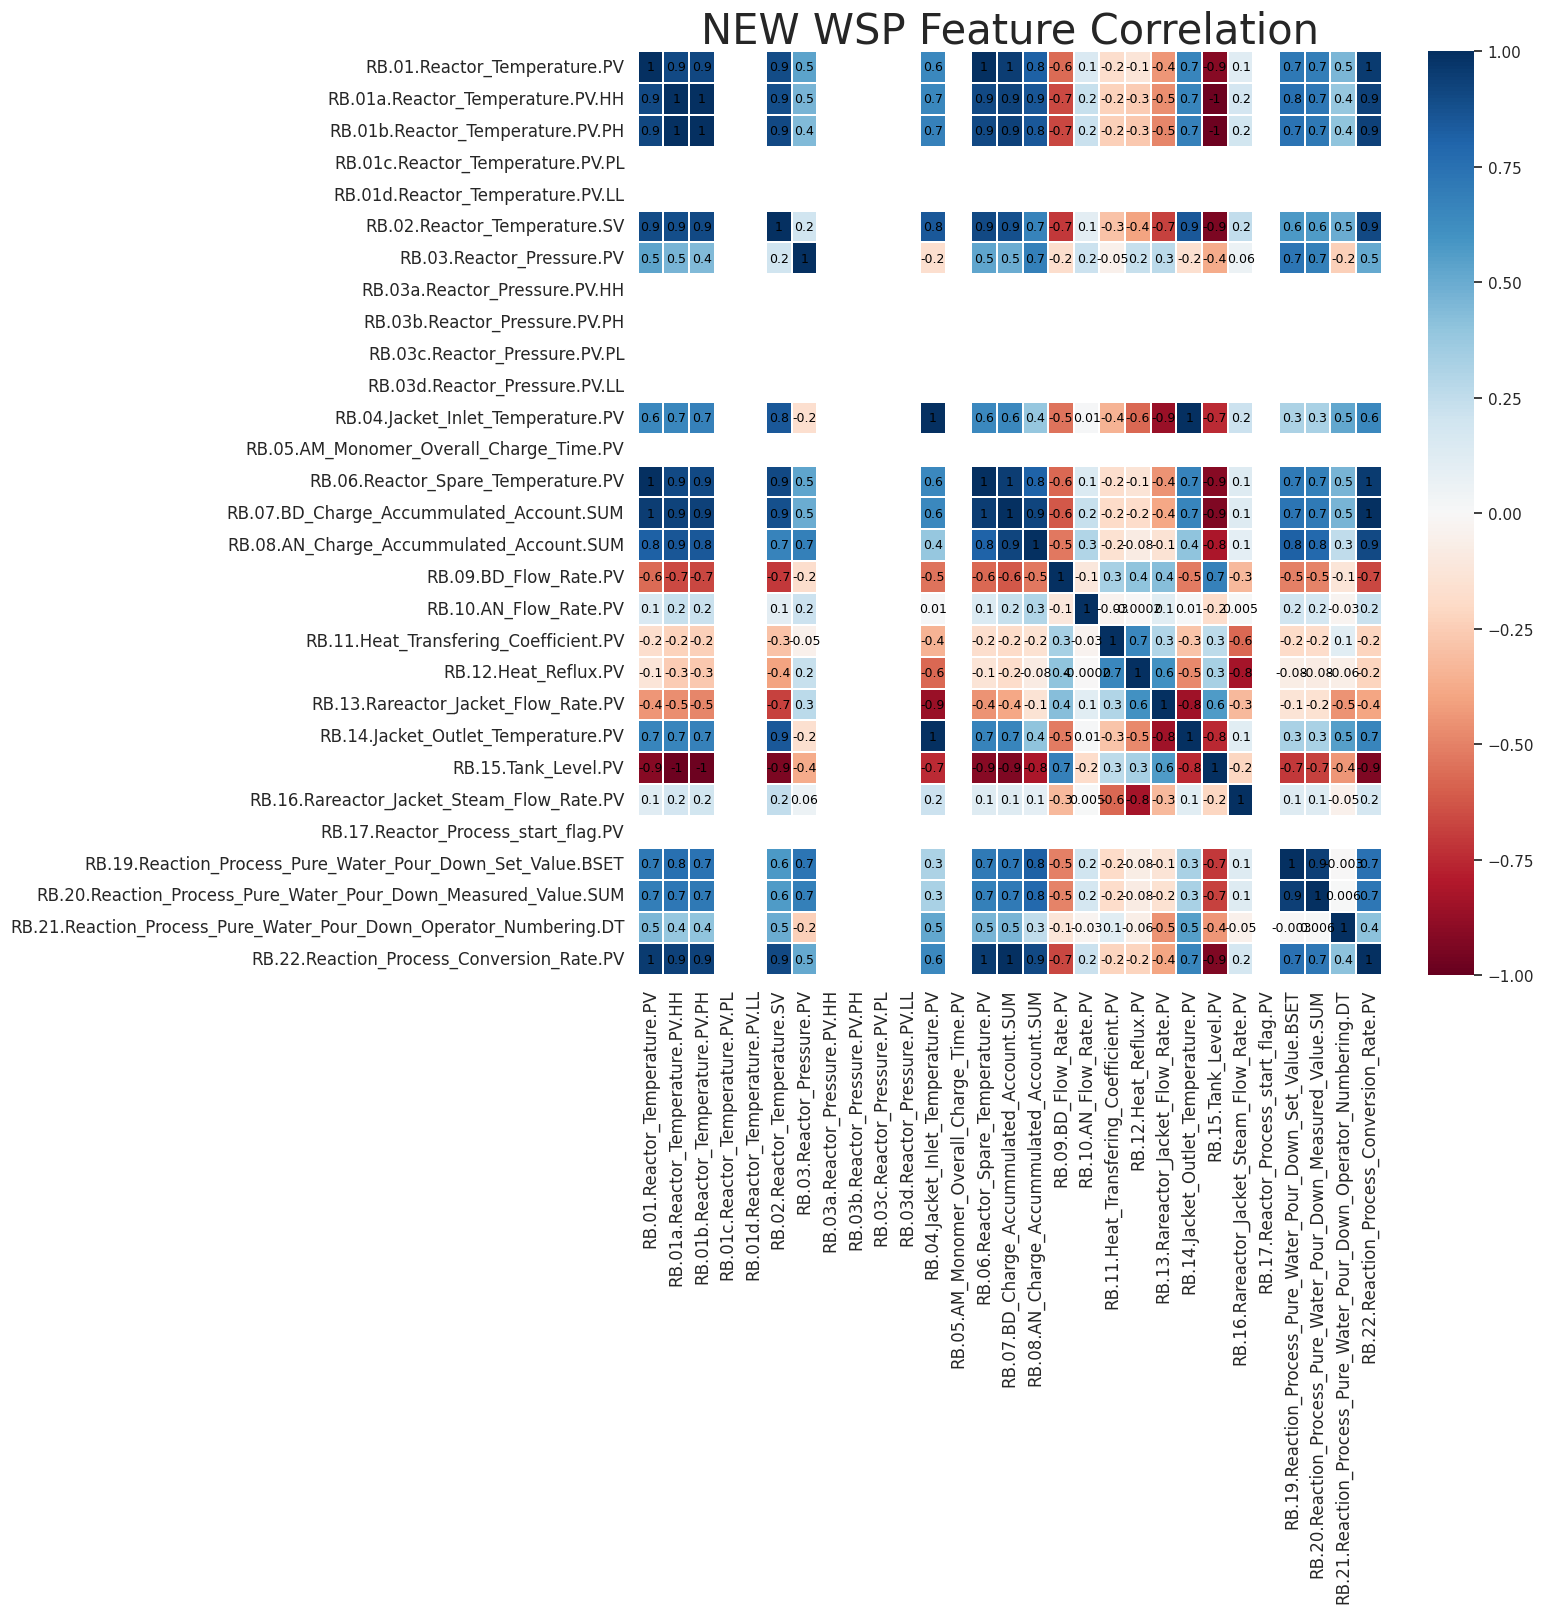

In [40]:
#data = pd.read_csv('20211006.csv', sep=',', encoding='utf-8') #小測試

def FeatureCorreate(data,dropData):#顏色越深（黑），相關係數越小，顏色越淺（白），相關係數越大def FeatureCorreate(datasets,dropData):2020 10 22
    sns.set(context="paper", font="monospace")
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(12,12)) #10 10
    train_corr = data.drop(dropData,axis=1).corr() #datasets.drop(dropData,axis=1).corr()    20201022

    cmap = sns.cubehelix_palette(start = 1, rot = 100, gamma=0.4, as_cmap = True)
    #ax = sns.heatmap(train_corr,cmap = 'RdBu',ax=ax,vmin=-1, vmax=1,annot=True,fmt ='0.1g',linewidths=.1, linecolor= 'white', mask=(train_corr<0.2),annot_kws={'size':9,'weight':'normal', 'color':'black'}) #藍底示字
    ax = sns.heatmap(train_corr,cmap = 'RdBu',ax=ax,vmin=-1, vmax=1,annot=True,fmt ='0.1g',linewidths=.1, linecolor= 'white',annot_kws={'size':9,'weight':'normal', 'color':'black'}) #藍底示字
    ax.set_xticklabels(train_corr.index, size=12)
    ax.set_yticklabels(train_corr.index, size=12) #train_corr.columns[::-1], size=15  20201606就是字體大小啦

    ax.set_title('NEW WSP Feature Correlation', fontsize=30)#30

print("Train Features")
FeatureCorreate(df,'Elapsed_Seconds')

In [42]:
print("--- 正在移除資料洩漏欄位... ---")
leaky_vars = [
        # 1. 冗餘的溫度測量 (備用溫度計) - 跟你要預測的 RB.01 相關性高達 1.0
        'RB.06.Reactor_Spare_Temperature.PV',

        # 2. 溫度的設定值 (SV) - 實際值 (PV) 當然會跟隨設定值 (SV)
        'RB.02.Reactor_Temperature.SV',

        # 3. 溫度警報 (HH, PH, PL, LL) - 這些是基於 PV 產生的，不是原因
        'RB.01a.Reactor_Temperature.PV.HH',
        'RB.01b.Reactor_Temperature.PV.PH',
        'RB.01c.Reactor_Temperature.PV.PL',
        'RB.01d.Reactor_Temperature.PV.LL',

        # 4. 壓力警報 (同理，這是壓力的結果)
        'RB.03a.Reactor_Pressure.PV.HH',
        'RB.03b.Reactor_Pressure.PV.PH',
        'RB.03c.Reactor_Pressure.PV.PL',
        'RB.03d.Reactor_Pressure.PV.LL',
    ]
df_for_heatmap = df.drop(columns=leaky_vars)
df_cleaned = df_for_heatmap.copy() # 未來的分析都基於 df_cleaned
print(df_cleaned.info())

--- 正在移除資料洩漏欄位... ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10596 entries, 0 to 10595
Data columns (total 20 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   RB.01.Reactor_Temperature.PV                                       10596 non-null  float64
 1   RB.03.Reactor_Pressure.PV                                          10596 non-null  float64
 2   RB.04.Jacket_Inlet_Temperature.PV                                  10596 non-null  float64
 3   RB.05.AM_Monomer_Overall_Charge_Time.PV                            10596 non-null  int64  
 4   RB.07.BD_Charge_Accummulated_Account.SUM                           10596 non-null  float64
 5   RB.08.AN_Charge_Accummulated_Account.SUM                           10596 non-null  float64
 6   RB.09.BD_Flow_Rate.PV                                              10596 non-null  float64
 7   


--- 正在產生清理後的熱圖 ---
--- 已儲存清理後的熱圖 (cleaned_heatmap.png) ---


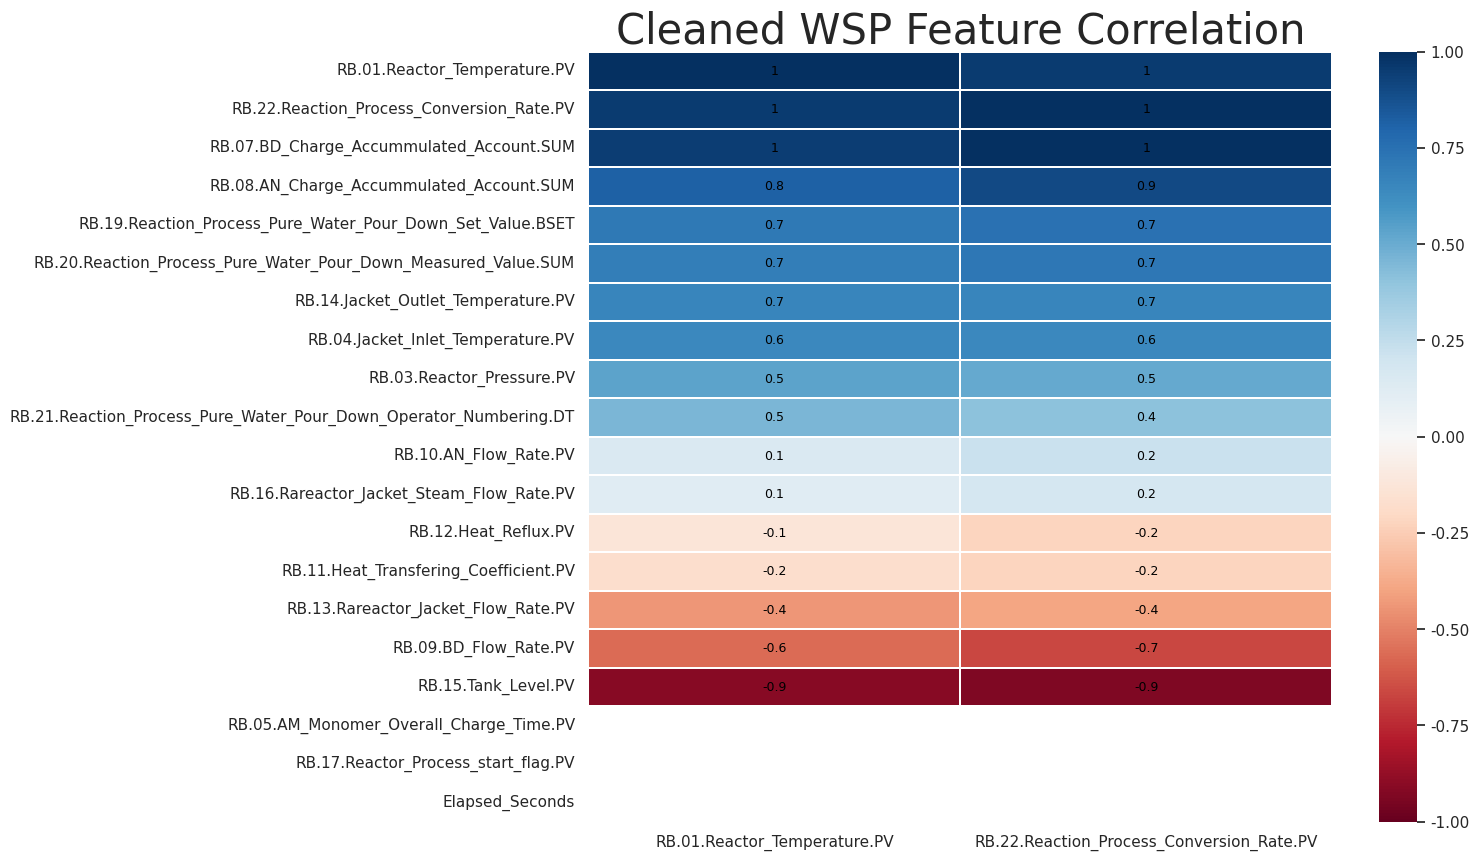

In [51]:
print("\n--- 正在產生清理後的熱圖 ---")
plt.figure(figsize=(12, 10))
# 由於欄位還是很多，我們只看與目標 (RB.01 和 RB.22) 的相關性
corr_matrix = df_cleaned.corr()
# 專注於兩個目標
target_corr = corr_matrix[['RB.01.Reactor_Temperature.PV', 'RB.22.Reaction_Process_Conversion_Rate.PV']].sort_values(by='RB.01.Reactor_Temperature.PV', ascending=False)

# sns.heatmap(target_corr, cmap='coolwarm', annot=True, fmt='.2f')
sns.heatmap(target_corr, cmap='RdBu',vmin=-1, vmax=1,annot=True,fmt ='0.1g',linewidths=.1, linecolor= 'white',annot_kws={'size':9,'weight':'normal', 'color':'black'}) #藍底示字

plt.title("Cleaned WSP Feature Correlation", fontsize=30)
plt.savefig("cleaned_heatmap.png", bbox_inches='tight')
print("--- 已儲存清理後的熱圖 (cleaned_heatmap.png) ---")

## **#用模型挑出跟溫度有高度相關的關鍵因子**

## StandardScaler & Train-Test-Split

In [22]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import numpy as np

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=5,scoring='neg_mean_squared_error')
    return pred.mean()

def print_evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [56]:
# 目標 (y1): 溫度
y_temp = df_cleaned['RB.01.Reactor_Temperature.PV']

# 特徵 (X1): 所有其他變數 (移除目標 y1 和 問題二的目標 y2)
# 我們也移除 'RB.22.Reaction_Process_Conversion_Rate.PV'，因為轉化率是溫度的「結果」，而非「原因」
X_temp = df_cleaned.drop(columns=['RB.01.Reactor_Temperature.PV', 'RB.22.Reaction_Process_Conversion_Rate.PV'])

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.2, random_state=1)

scaler_temp = StandardScaler()
X_train_temp_scaled = scaler_temp.fit_transform(X_train_temp)
X_test_temp_scaled = scaler_temp.transform(X_test_temp)

# Ridge Regression 模型與關鍵因子分析

In [60]:
from sklearn.linear_model import Ridge

# 訓練 Ridge 模型
model_ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
model_ridge.fit(X_train_temp_scaled, y_train_temp)

print("--- Ridge 溫度模型 訓練完成 ---")
print("--- 溫度模型評估 (Test Set) ---")
ridge_test_pred = model_ridge.predict(X_test_temp_scaled)
print_evaluate(y_test_temp, ridge_test_pred)

# (來自 Cell 19) - 分析關鍵因子
ridge_coef = pd.DataFrame(
    data=model_ridge.coef_,
    index=X_temp.columns,
    columns=['Coefficient']
)

print('\n--- 關鍵因子分析 (Ridge 係數) ---')
# 按照係數的「絕對值」大小排序
ridge_coef_sorted = ridge_coef.reindex(ridge_coef.abs().sort_values(by='Coefficient', ascending=False).index)

print(ridge_coef_sorted.to_markdown(floatfmt=".4f"))

--- Ridge 溫度模型 訓練完成 ---
--- 溫度模型評估 (Test Set) ---
MAE: 1.0762522941475337
MSE: 2.010656518493874
RMSE: 1.4179762051931175
R2 Square 0.9864144671033186
__________________________________

--- 關鍵因子分析 (Ridge 係數) ---
|                                                                   |   Coefficient |
|:------------------------------------------------------------------|--------------:|
| RB.07.BD_Charge_Accummulated_Account.SUM                          |        8.5899 |
| RB.08.AN_Charge_Accummulated_Account.SUM                          |       -4.7797 |
| RB.03.Reactor_Pressure.PV                                         |        4.6863 |
| RB.12.Heat_Reflux.PV                                              |        3.2067 |
| RB.15.Tank_Level.PV                                               |       -3.0657 |
| RB.16.Rareactor_Jacket_Steam_Flow_Rate.PV                         |        1.9466 |
| RB.14.Jacket_Outlet_Temperature.PV                                |        1.7990 |
| RB.04.Jacke

--- 已儲存問題一的因子分析圖 (problem1_ridge_factors.png) ---


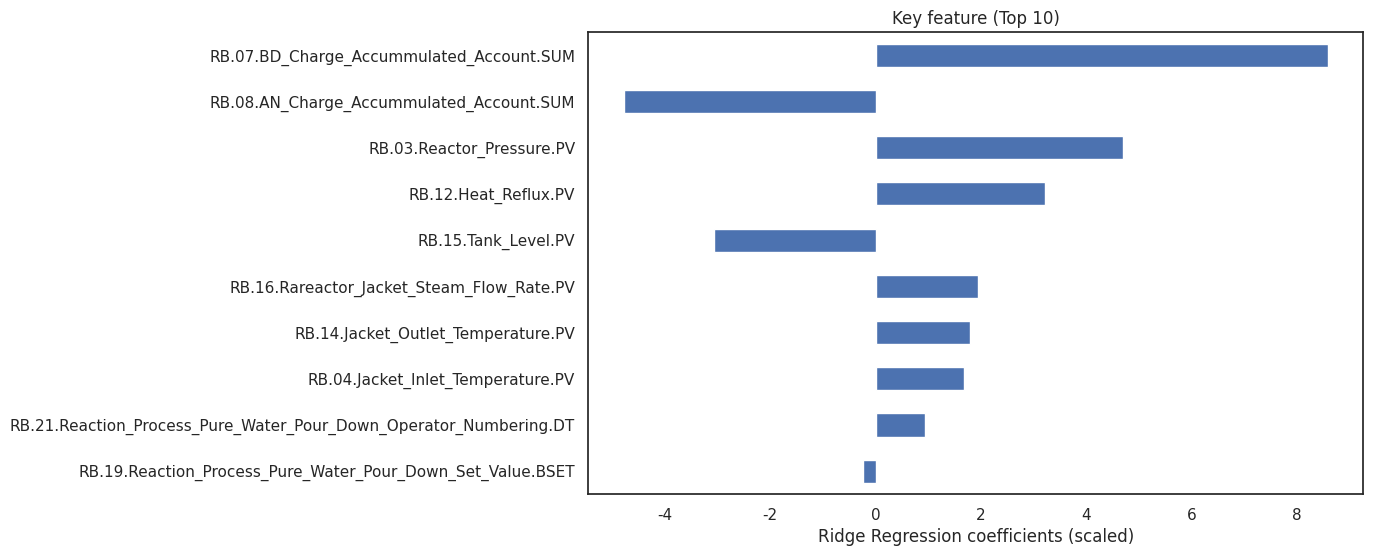

In [63]:
# 繪製因子重要性圖
plt.figure(figsize=(10, 6))
ridge_coef_sorted.head(10)['Coefficient'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Key feature (Top 10)")
plt.xlabel("Ridge Regression coefficients (scaled)")
plt.savefig("problem1_ridge_factors.png", bbox_inches='tight')
print("--- 已儲存問題一的因子分析圖 (problem1_ridge_factors.png) ---")

## AI 模擬機 : RandomForest



In [64]:
print("\n--- 正在訓練 XGBoost 模擬機 ---")

y_conv = df_cleaned['RB.22.Reaction_Process_Conversion_Rate.PV']

# 特徵 (X2): 所有其他變數 (這次要「包含」溫度)
X_conv = df_cleaned.drop(columns=['RB.22.Reaction_Process_Conversion_Rate.PV'])

# (註：RandomForest 樹模型不需要特徵縮放，我們使用原始的 X_conv)
X_train_conv, X_test_conv, y_train_conv, y_test_conv = train_test_split(X_conv, y_conv, test_size=0.2, random_state=1)

print(f"X_train_conv: {X_train_conv.shape}, y_train_conv: {y_train_conv.shape}")

rf_model = RandomForestRegressor(
    n_estimators=100,  # 100 棵樹
    max_depth=10,       # 限制深度以防過擬合
    random_state=42,
    n_jobs=-1           # 使用所有 CPU 核心
)

rf_model.fit(X_train_conv, y_train_conv)
print("--- RandomForest 轉化率模擬機 訓練完成 ---")

# 評估模型
rf_test_pred = rf_model.predict(X_test_conv)

print('\n--- 問題二：RandomForest 轉化率模擬機 評估 ---')
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_conv, rf_test_pred)


--- 正在訓練 XGBoost 模擬機 ---
X_train_conv: (8476, 19), y_train_conv: (8476,)
--- RandomForest 轉化率模擬機 訓練完成 ---

--- 問題二：RandomForest 轉化率模擬機 評估 ---
Test set evaluation:
_____________________________________
MAE: 0.011266670184785034
MSE: 0.00032455229668794063
RMSE: 0.018015335042344913
R2 Square 0.9999991579177729
__________________________________


## RandomForest Feature Importance


--- 【問題二解答】：影響產量(轉化率)的關鍵因子 (RandomForest) ---
(重要性越高，代表對轉化率的影響越顯著)
|                                                                   |   Importance |
|:------------------------------------------------------------------|-------------:|
| RB.01.Reactor_Temperature.PV                                      |       0.7388 |
| RB.08.AN_Charge_Accummulated_Account.SUM                          |       0.1590 |
| RB.07.BD_Charge_Accummulated_Account.SUM                          |       0.0933 |
| RB.15.Tank_Level.PV                                               |       0.0028 |
| RB.03.Reactor_Pressure.PV                                         |       0.0022 |
| RB.14.Jacket_Outlet_Temperature.PV                                |       0.0012 |
| RB.04.Jacket_Inlet_Temperature.PV                                 |       0.0011 |
| RB.12.Heat_Reflux.PV                                              |       0.0008 |
| RB.11.Heat_Transfering_Coefficient.PV                             |       0.0004

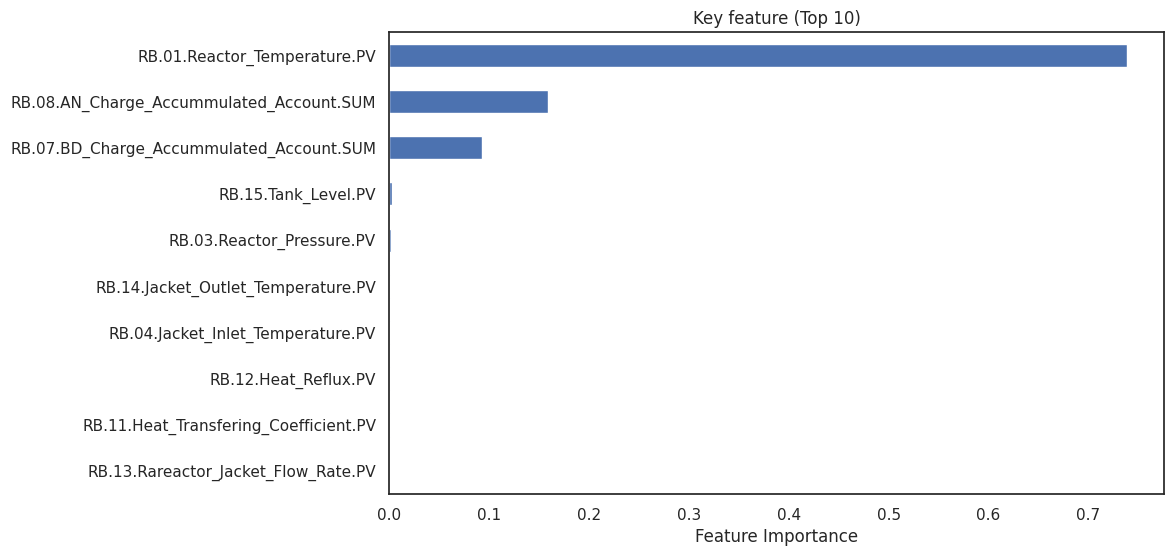

In [66]:
rf_importance = pd.DataFrame(
    data=rf_model.feature_importances_,
    index=X_conv.columns,
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

print('\n--- 【問題二解答】：影響產量(轉化率)的關鍵因子 (RandomForest) ---')
print("(重要性越高，代表對轉化率的影響越顯著)")
print(rf_importance.to_markdown(floatfmt=".4f"))

# 繪製因子重要性圖

plt.figure(figsize=(10, 6))
rf_importance.head(10)['Importance'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Key feature (Top 10)")
plt.xlabel("Feature Importance")
plt.savefig("problem2_rf_factors.png", bbox_inches='tight')
print("--- 已儲存問題二的因子分析圖 (problem2_rf_factors.png) ---")

print("\n--- 全部分析完成 ---")

# 如何利用 AI 提高產量？
我們將使用 AI 模擬機進行 'What-if' 情境模擬

In [74]:
baseline_scenario = X_conv.mean().to_frame().T
print(f"基準 (平均) 產量預測: {rf_model.predict(baseline_scenario)[0]:.4f}")

# 步驟 2: 模擬「調高關鍵因子」
# 根據 Cell 11 的特徵重要性，假設 'RB.08' (AN_Charge_Accummulated_Account.SUM) 很重要
# 我們來模擬將RB.08.AN_Charge_Accummulated_Account.SUM提高 10%
scenario_A = baseline_scenario.copy()
scenario_A['RB.08.AN_Charge_Accummulated_Account.SUM'] *= 1.10 # 提高 10%

print(f"情境 A (AN_Charge_Accummulated_Account.SUM提高10%) 產量預測: {rf_model.predict(scenario_A)[0]:.4f}")

# 步驟 3: 模擬「多重調整」
# 假設我們同時提高AN_Charge_Accummulated_Account.SUM，並嘗試提高溫度
scenario_B = baseline_scenario.copy()
scenario_B['RB.08.AN_Charge_Accummulated_Account.SUM'] *= 1.1 # 提高 10%
scenario_B['RB.01.Reactor_Temperature.PV'] *= 1.05 # 提高 5% (假設)

print(f"情境 B (AN_Charge_Accummulated_Account.SUM+10%, 溫度+5%) 產量預測: {rf_model.predict(scenario_B)[0]:.4f}")


基準 (平均) 產量預測: 65.8293
情境 A (AN_Charge_Accummulated_Account.SUM提高10%) 產量預測: 72.8571
情境 B (AN_Charge_Accummulated_Account.SUM+10%, 溫度+5%) 產量預測: 73.7685


## 總結報告：反應器 AI 分析

報告人：(你的名字)
日期：2025-11-15

### 經理問題一：影響反應器溫度的「關鍵因子」是什麼？

根據 Ridge 迴歸模型分析 (已排除資料洩漏)，影響 `RB.01` 溫度的關鍵製程因子前三名為：

1.  **因子一** ：`RB.07.BD_Charge_Accummulated_Account.SUM` (係數: 8.5899)
2.  **因子二**：`RB.08.AN_Charge_Accummulated_Account.SUM` (係數: -4.7797)
3.  **因子三**：`RB.03.Reactor_Pressure.PV` (係數: 4.6863)

--- 溫度模型評估 (Test Set) ---
R2 Square 0.9864144671033186
__________________________________

--- 關鍵因子分析 (Ridge 係數) ---
|                                                                   |   Coefficient |
|:------------------------------------------------------------------|--------------:|
| RB.07.BD_Charge_Accummulated_Account.SUM                          |        8.5899 |
| RB.08.AN_Charge_Accummulated_Account.SUM                          |       -4.7797 |
| RB.03.Reactor_Pressure.PV                                         |        4.6863 |
| RB.12.Heat_Reflux.PV                                              |        3.2067 |
| RB.15.Tank_Level.PV                                               |       -3.0657 |
| RB.16.Rareactor_Jacket_Steam_Flow_Rate.PV                         |        1.9466 |
| RB.14.Jacket_Outlet_Temperature.PV                                |        1.7990 |
| RB.04.Jacket_Inlet_Temperature.PV                                 |        1.6769 |
| RB.21.Reaction_Process_Pure_Water_Pour_Down_Operator_Numbering.DT |        0.9369 |
| RB.19.Reaction_Process_Pure_Water_Pour_Down_Set_Value.BSET        |       -0.2389 |
| RB.13.Rareactor_Jacket_Flow_Rate.PV                               |       -0.2048 |
| RB.10.AN_Flow_Rate.PV                                             |       -0.1940 |
| RB.11.Heat_Transfering_Coefficient.PV                             |       -0.1643 |
| RB.20.Reaction_Process_Pure_Water_Pour_Down_Measured_Value.SUM    |       -0.1449 |
| RB.09.BD_Flow_Rate.PV                                             |        0.0432 |
| RB.05.AM_Monomer_Overall_Charge_Time.PV                           |        0.0000 |
| RB.17.Reactor_Process_start_flag.PV                               |        0.0000 |
| Elapsed_Seconds                                                   |        0.0000 |

---

### 經理問題二：如何利用 AI 提高「產量 (轉化率)」？

我們成功建立了一個高準確度的「轉化率 AI 模擬機」(RandomForest 模型，R2 達到 0.99)。

**1. 影響產量的關鍵因子：**
根據 AI 分析，影響 `RB.22` 轉化率的最重要因子為：
| RB.01.Reactor_Temperature.PV                                      |       0.7388 |
| RB.08.AN_Charge_Accummulated_Account.SUM                          |       0.1590 |
| RB.07.BD_Charge_Accummulated_Account.SUM                          |       0.0933 |

1.  **因子一**：`RB.01.Reactor_Temperature.PV` (重要性: 0.7388)
2.  **因子二**：`RB.08.AN_Charge_Accummulated_Account.SUM` (重要性: 0.1590)
3.  **因子三**：`RB.07.BD_Charge_Accummulated_Account.SUM` (重要性: 0.0933)

**2. AI 情境模擬 (What-if)：**
利用此模型，我們模擬了調整關鍵因子對產量的影響：

* **基準情境 (平均值)**：產量預測: **65.8293**
* **情境 A (AN_Charge_Accummulated_Account.SUM提高10%)**：產量預測提升至 **72.8571**
* **情境 B (AN_Charge_Accummulated_Account.SUM+10%, 溫度+5%)**：產量預測提升至 **73.7685**
